In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
import itertools
import tensorflow as tf

from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Input, Conv2D, MaxPooling2D
from keras.optimizers import Adam, Adadelta
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.np_utils import to_categorical

In [2]:
train_dir = '../thesis_program/data_image/train'
test_dir = '../thesis_program/data_image/test'
hiragana_train_dir = train_dir+"/Hiragana"
katakana_train_dir = train_dir+"/Katakana"
hiragana_test_dir = test_dir+"/Hiragana"
katakana_test_dir = test_dir+"/Katakana"
sample_submission = pd.read_csv('../thesis_program/sample_submission.csv')

In [3]:
letter_labels = [
    [0, "A", "A"], [1, "Ba", "Ba"], [2, "Be", "Be"], [3, "Bi", "Bi"], [4, "Bo", "Bo"], [5, "Bu", "Bu"],
    [6, "Bya", "Bya"], [7, "Byo", "Byo"], [8, "Byu", "Byu"], [9, "Cha", "Cha"], [10, "Chi", "Chi"],
    [11, "Cho", "Cho"], [12, "Chu", "Chu"], [13, "Da", "Da"], [14, "De", "De"], [15, "Do", "Do"],
    [16, "E", "E"], [17, "Fu", "Fu"], [18, "Ga", "Ga"], [19, "Ge", "Ge"], [20, "Gi", "Gi"],
    [21, "Go", "Go"], [22, "Gu", "Gu"], [23, "Gya", "Gya"], [24, "Gyo", "Gyo"], [25, "Gyu", "Gyu"],
    [26, "Ha", "Ha"], [27, "He", "He"], [28, "Hi", "Hi"], [29, "Ho", "Ho"], [30, "Hya", "Hya"],
    [31, "Hyo", "Hyo"], [32, "Hyu", "Hyu"], [33, "I", "I"], [34, "Ja", "Ja"], [35, "Ji", "Ji"],
    [36, "Ji_2", "Ji"], [37, "Jo", "Jo"], [38, "Ju", "Ju"], [39, "Ka", "Ka"], [40, "Ke", "Ke"],
    [41, "Ki", "Ki"], [42, "Ko", "Ko"], [43, "Ku", "Ku"], [44, "Kya", "Kya"], [45, "Kyo", "Kyo"],
    [46, "Kyu", "Kyu"], [47, "Ma", "Ma"], [48, "Me", "Me"], [49, "Mi", "Mi"], [50, "Mo", "Mo"],
    [51, "Mu", "Mu"], [52, "Mya", "Mya"], [53, "Myo", "Myo"], [54, "Myu", "Myu"], [55, "N", "N"],
    [56, "Na", "Na"], [57, "Ne", "Ne"], [58, "Ni", "Ni"], [59, "No", "No"], [60, "Nu", "Nu"],
    [61, "Nya", "Nya"], [62, "Nyo", "Nyo"], [63, "Nyu", "Nyu"], [64, "O", "O"], [65, "Pa", "Pa"],
    [66, "Pe", "Pe"], [67, "Pi", "Pi"], [68, "Po", "Po"], [69, "Pu", "Pu"], [70, "Pya", "Pya"],
    [71, "Pyo", "Pyo"], [72, "Pyu", "Pyu"], [73, "Ra", "Ra"], [74, "Re", "Re"], [75, "Ri", "Ri"],
    [76, "Ro", "Ro"], [77, "Ru", "Ru"], [78, "Rya", "Rya"], [79, "Ryo", "Ryo"], [80, "Ryu", "Ryu"],
    [81, "Sa", "Sa"], [82, "Se", "Se"], [83, "Sha", "Sha"], [84, "Shi", "Shi"], [85, "Sho", "Sho"],
    [86, "Shu", "Shu"], [87, "So", "So"], [88, "Su", "Su"], [89, "Ta", "Ta"], [90, "Te", "Te"],
    [91, "To", "To"], [92, "Tsu", "Tsu"], [93, "U", "U"], [94, "Wa", "Wa"], [95, "Wo", "Wo"],
    [96, "Ya", "Ya"], [97, "Yo", "Yo"], [98, "Yu", "Yu"], [99, "Za", "Za"], [100, "Ze", "Ze"],
    [101, "Zo", "Zo"], [102, "Zu", "Zu"], [103, "Zu_2", "Zu"], [104, "A", "A"], [105, "Ba", "Ba"],
    [106, "Be", "Be"], [107, "Bi", "Bi"], [108, "Bo", "Bo"], [109, "Bu", "Bu"], [110, "Bya", "Bya"],
    [111, "Byo", "Byo"], [112, "Byu", "Byu"], [113, "Cha", "Cha"], [114, "Che", "Che"], [115, "Chi", "Chi"],
    [116, "Cho", "Cho"], [117, "Chu", "Chu"], [118, "Da", "Da"], [119, "De", "De"], [120, "Di", "Di"],
    [121, "Do", "Do"], [122, "Du", "Du"], [123, "Dyu", "Dyu"], [124, "E", "E"], [125, "Fa", "Fa"],
    [126, "Fe", "Fe"], [127, "Fi", "Fi"], [128, "Fo", "Fo"], [129, "Fu", "Fu"], [130, "Ga", "Ga"],
    [131, "Ge", "Ge"], [132, "Gi", "Gi"], [133, "Go", "Go"], [134, "Gu", "Gu"], [135, "Gya", "Gya"],
    [136, "Gyo", "Gyo"], [137, "Gyu", "Gyu"], [138, "Ha", "Ha"], [139, "He", "He"], [140, "Hi", "Hi"],
    [141, "Ho", "Ho"], [142, "Hya", "Hya"], [143, "Hyo", "Hyo"], [144, "Hyu", "Hyu"], [145, "I", "I"],
    [146, "Ja", "Ja"], [147, "Je", "Je"], [148, "Ji", "Ji"], [149, "Ji_2", "Ji"], [150, "Jo", "Jo"],
    [151, "Ju", "Ju"], [152, "Ka", "Ka"], [153, "Ke", "Ke"], [154, "Ki", "Ki"], [155, "Ko", "Ko"],
    [156, "Ku", "Ku"], [157, "Kya", "Kya"], [158, "Kyo", "Kyo"], [159, "Kyu", "Kyu"], [160, "Ma", "Ma"],
    [161, "Me", "Me"], [162, "Mi", "Mi"], [163, "Mo", "Mo"], [164, "Mu", "Mu"], [165, "Mya", "Mya"],
    [166, "Myo", "Myo"], [167, "Myu", "Myu"], [168, "N", "N"], [169, "Na", "Na"], [170, "Ne", "Ne"],
    [171, "Ni", "Ni"], [172, "No", "No"], [173, "Nu", "Nu"], [174, "Nya", "Nya"], [175, "Nyo", "Nyo"],
    [176, "Nyu", "Nyu"], [177, "O", "O"], [178, "Pa", "Pa"], [179, "Pe", "Pe"], [180, "Pi", "Pi"],
    [181, "Po", "Po"], [182, "Pu", "Pu"], [183, "Pya", "Pya"], [184, "Pyo", "Pyo"], [185, "Pyu", "Pyu"],
    [186, "Ra", "Ra"], [187, "Re", "Re"], [188, "Ri", "Ri"], [189, "Ro", "Ro"], [190, "Ru", "Ru"],
    [191, "Rya", "Rya"], [192, "Ryo", "Ryo"], [193, "Ryu", "Ryu"], [194, "Sa", "Sa"], [195, "Se", "Se"],
    [196, "Sha", "Sha"], [197, "She", "She"], [198, "Shi", "Shi"], [199, "Sho", "Sho"], [200, "Shu", "Shu"],
    [201, "So", "So"], [202, "Su", "Su"], [203, "Ta", "Ta"], [204, "Te", "Te"], [205, "Ti", "Ti"],
    [206, "To", "To"], [207, "Tsa", "Tsa"], [208, "Tse", "Tse"], [209, "Tso", "Tso"], [210, "Tsu", "Tsu"],
    [211, "Tu", "Tu"], [212, "U", "U"], [213, "Wa", "Wa"], [214, "We", "We"], [215, "Wi", "Wi"],
    [216, "Wo", "Wo"], [217, "Wo_2", "Wo"], [218, "Ya", "Ya"], [219, "Yo", "Yo"], [220, "Yu", "Yu"],
    [221, "Za", "Za"], [222, "Ze", "Ze"], [223, "Zo", "Zo"], [224, "Zu", "Zu"], [225, "Zu_2", "Zu"]
]

In [4]:
print('Train Data')
for label in letter_labels:
    if label[0] >= 104:
        print('{} {} images'.format(label[1], len(os.listdir(os.path.join(katakana_train_dir,
                                                                          "Katakana_"+label[2])))))
    else :
        print('{} {} images'.format(label[1], len(os.listdir(os.path.join(hiragana_train_dir,
                                                                          "Hiragana_"+label[2])))))

print('Test Data')
for label in letter_labels:
    if label[0] >= 104:
        print('{} {} images'.format(label[1], len(os.listdir(os.path.join(katakana_train_dir,
                                                                          "Katakana_"+label[2])))))
    else :
        print('{} {} images'.format(label[1], len(os.listdir(os.path.join(hiragana_train_dir,
                                                                          "Hiragana_"+label[2])))))

Train Data
A 46 images
Ba 46 images
Be 46 images
Bi 46 images
Bo 46 images
Bu 46 images
Bya 46 images
Byo 46 images
Byu 46 images
Cha 46 images
Chi 46 images
Cho 46 images
Chu 46 images
Da 46 images
De 46 images
Do 46 images
E 46 images
Fu 46 images
Ga 46 images
Ge 46 images
Gi 46 images
Go 46 images
Gu 46 images
Gya 46 images
Gyo 46 images
Gyu 46 images
Ha 46 images
He 46 images
Hi 46 images
Ho 46 images
Hya 46 images
Hyo 46 images
Hyu 46 images
I 46 images
Ja 46 images
Ji 46 images
Ji_2 46 images
Jo 46 images
Ju 46 images
Ka 46 images
Ke 46 images
Ki 46 images
Ko 46 images
Ku 46 images
Kya 46 images
Kyo 46 images
Kyu 46 images
Ma 46 images
Me 46 images
Mi 46 images
Mo 46 images
Mu 46 images
Mya 46 images
Myo 46 images
Myu 46 images
N 46 images
Na 46 images
Ne 46 images
Ni 46 images
No 46 images
Nu 46 images
Nya 46 images
Nyo 46 images
Nyu 46 images
O 46 images
Pa 46 images
Pe 46 images
Pi 46 images
Po 46 images
Pu 46 images
Pya 46 images
Pyo 46 images
Pyu 46 images
Ra 46 images
Re 46

In [5]:
train = []

for label_num, label in enumerate(letter_labels):
    if label[0] >= 104:
        for file in os.listdir(os.path.join(katakana_train_dir, "Katakana_"+label[1])):
            train.append(['{}/{}/{}'.format(katakana_train_dir, "Katakana_"+label[1], file), label_num, label[1]])
    else :
        for file in os.listdir(os.path.join(hiragana_train_dir, "Hiragana_"+label[1])):
            train.append(['{}/{}/{}'.format(hiragana_train_dir, "Hiragana_"+label[1], file), label_num, label[1]])

train = pd.DataFrame(train, columns=['file', 'label_num', 'english_word'])

print('Training Data: ',train.shape)
print(train.head(5))

Training Data:  (10396, 3)
                                                file  label_num english_word
0  ../thesis_program/data_image/train/Hiragana/Hi...          0            A
1  ../thesis_program/data_image/train/Hiragana/Hi...          0            A
2  ../thesis_program/data_image/train/Hiragana/Hi...          0            A
3  ../thesis_program/data_image/train/Hiragana/Hi...          0            A
4  ../thesis_program/data_image/train/Hiragana/Hi...          0            A


In [7]:
x_train = []

for i in range(len(train)):
    file_name = format(train['file'][i])
    img = cv2.imread(file_name)
    img_resize = cv2.resize(img,dsize=(66,66))
    grayImage = cv2.cvtColor(img_resize, cv2.COLOR_BGR2GRAY)
    (thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 127, 1, cv2.THRESH_BINARY)
    img_erotion = cv2.erode(blackAndWhiteImage, np.ones((3, 3), np.uint8), iterations=2)
    img_morph_open = cv2.morphologyEx(img_erotion, cv2.MORPH_OPEN, np.ones((2, 2), np.uint8), iterations=3)
    img_morph_close = cv2.morphologyEx(img_morph_open, cv2.MORPH_CLOSE, np.ones((2, 2), np.uint8), iterations=3)
    img_dilation = cv2.dilate(img_morph_close, np.ones((3, 3), np.uint8), iterations=1)
    img_stack = np.reshape(img_dilation,(66,66,1))
    x_train.append(np.concatenate((np.array(img_resize),np.array(img_stack)),axis=2))

x_train = np.array(x_train)

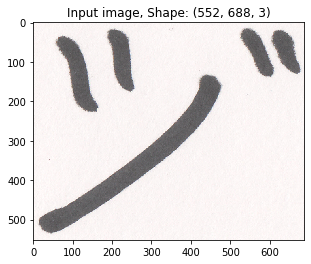

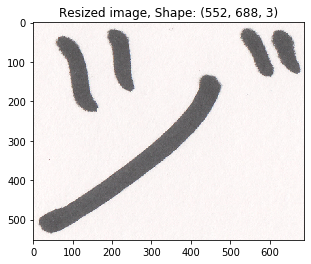

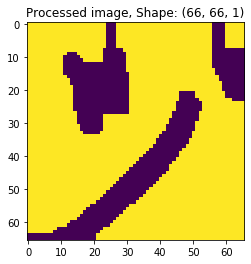

In [8]:
Input_image = cv2.imread(train['file'][len(train)-1])

plt.imshow(Input_image)
plt.title('Input image, Shape: '+str(Input_image.shape))
plt.show()

plt.imshow(img)
plt.title('Resized image, Shape: '+str(img.shape))
plt.show()

plt.imshow(np.reshape(img_stack,(66,66)))
plt.title('Processed image, Shape: '+str(img_stack.shape))
plt.show()

In [9]:
labels = train['label_num']
labels = to_categorical(labels, num_classes = len(letter_labels))

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x_train, labels, test_size = 0.1, random_state=10)

In [11]:
input_shape = x_train[1].shape
print('Input Shape is :', input_shape)

Input Shape is : (66, 66, 4)


In [12]:
test = []

for label_num, label in enumerate(letter_labels):
    if label[0] >= 104:
        for file in os.listdir(os.path.join(katakana_test_dir, "Katakana_"+label[1])):
            test.append(['{}/{}/{}'.format(katakana_test_dir, "Katakana_"+label[1], file), label_num, label[1]])
    else:
        for file in os.listdir(os.path.join(hiragana_test_dir, "Hiragana_"+label[1])):
            test.append(['{}/{}/{}'.format(hiragana_test_dir, "Hiragana_"+label[1], file), label_num, label[1]])

test = pd.DataFrame(test, columns=['file', 'label_num', 'english_word'])
print(test.head(5))

                                                file  label_num english_word
0  ../thesis_program/data_image/test/Hiragana/Hir...          0            A
1  ../thesis_program/data_image/test/Hiragana/Hir...          0            A
2  ../thesis_program/data_image/test/Hiragana/Hir...          0            A
3  ../thesis_program/data_image/test/Hiragana/Hir...          0            A
4  ../thesis_program/data_image/test/Hiragana/Hir...          0            A


In [13]:

x_test = []

for i in range(len(test)):
    img = cv2.imread(test['file'][i])
    img_resize = cv2.resize(img,dsize=(66,66))
    grayImage = cv2.cvtColor(img_resize, cv2.COLOR_BGR2GRAY)
    (thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 127, 1, cv2.THRESH_BINARY)
    img_erotion = cv2.erode(blackAndWhiteImage, np.ones((3, 3), np.uint8), iterations=2)
    img_morph_open = cv2.morphologyEx(img_erotion, cv2.MORPH_OPEN, np.ones((2, 2), np.uint8), iterations=3)
    img_morph_close = cv2.morphologyEx(img_morph_open, cv2.MORPH_CLOSE, np.ones((2, 2), np.uint8), iterations=3)
    img_dilation = cv2.dilate(img_morph_close, np.ones((3, 3), np.uint8), iterations=1)
    img_stack = np.reshape(img_dilation,(66,66,1))
    x_test.append(np.concatenate((np.array(img_resize),np.array(img_stack)),axis=2))

x_test = np.array(x_test)

test_shape = x_test[1].shape
print('Test Shape is :', test_shape)

y_test = test['label_num']
y_test = to_categorical(y_test, num_classes = len(letter_labels))

Test Shape is : (66, 66, 4)


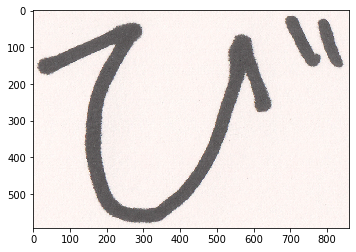

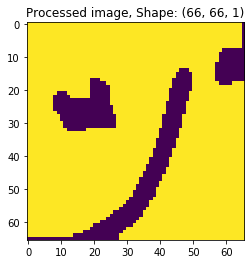

In [27]:
randm = np.random.randint(0,len(test))

img = cv2.imread(test['file'][randm])
plt.imshow(img)
plt.show()

plt.imshow(np.reshape(img_stack,(66,66)))
plt.title('Processed image, Shape: '+str(img_stack.shape))
plt.show()

In [15]:
def fire_incept(x, fire=16, intercept=64):
    x = Conv2D(fire, (5,5), strides=(2,2))(x)
    x = LeakyReLU(alpha=0.15)(x)

    left = Conv2D(intercept, (3,3), padding='same')(x)
    left = LeakyReLU(alpha=0.15)(left)

    right = Conv2D(intercept, (5,5), padding='same')(x)
    right = LeakyReLU(alpha=0.15)(right)

    x = concatenate([left, right], axis=3)
    x = MaxPooling2D(strides=2, pool_size=3)(x)
    return x

def fire_squeeze(x, fire=16, intercept=64):
    x = Conv2D(fire, (1,1))(x)
    x = LeakyReLU(alpha=0.15)(x)

    left = Conv2D(intercept, (1,1))(x)
    left = LeakyReLU(alpha=0.15)(left)

    right = Conv2D(intercept, (3,3), padding='same')(x)
    right = LeakyReLU(alpha=0.15)(right)

    x = concatenate([left, right], axis=3)
    x = MaxPooling2D(strides=2, pool_size=1)(x)
    return x

image_input=Input(shape=input_shape)

x = fire_incept(image_input, fire=16, intercept=16)

x = fire_squeeze(x, fire=32, intercept=32)

x = fire_squeeze(x, fire=64, intercept=64)

x = fire_squeeze(x, fire=64, intercept=64)

x = Conv2D(64, (2,2))(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(strides=2, pool_size=1)(x)

x = Flatten()(x)

x = Dense(512)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.1)(x)

out = Dense(len(letter_labels), activation='softmax')(x)

model_new = Model(image_input, out)
model_new.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 66, 66, 4)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 31, 31, 16)   1616        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 31, 31, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 31, 31, 16)   2320        leaky_re_lu[0][0]                
_______________________________________________________________________________________

In [16]:
model_new.compile(optimizer = Adam(lr=.00025) , loss = 'categorical_crossentropy', metrics=['accuracy'])

model_new.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), batch_size = 32, epochs=100)

Epoch 1/100
293/293 [==============================] - 60s 204ms/step - loss: 4.9022 - accuracy: 0.0535 - val_loss: 2.9578 - val_accuracy: 0.2644
Epoch 2/100
293/293 [==============================] - 65s 223ms/step - loss: 2.2738 - accuracy: 0.3969 - val_loss: 1.5462 - val_accuracy: 0.5538
Epoch 3/100
293/293 [==============================] - 58s 196ms/step - loss: 1.3664 - accuracy: 0.5876 - val_loss: 1.2081 - val_accuracy: 0.6385
Epoch 4/100
293/293 [==============================] - 54s 183ms/step - loss: 0.9747 - accuracy: 0.6890 - val_loss: 0.9633 - val_accuracy: 0.7019
Epoch 5/100
293/293 [==============================] - 48s 164ms/step - loss: 0.7358 - accuracy: 0.7576 - val_loss: 0.8312 - val_accuracy: 0.7423
Epoch 6/100
293/293 [==============================] - 43s 146ms/step - loss: 0.5597 - accuracy: 0.8090 - val_loss: 0.7124 - val_accuracy: 0.7683
Epoch 7/100
293/293 [==============================] - 43s 148ms/step - loss: 0.4325 - accuracy: 0.8511 - val_loss: 0.6658 -

Epoch 57/100
293/293 [==============================] - 42s 143ms/step - loss: 0.0390 - accuracy: 0.9874 - val_loss: 1.0145 - val_accuracy: 0.8558
Epoch 58/100
293/293 [==============================] - 42s 143ms/step - loss: 0.0410 - accuracy: 0.9871 - val_loss: 0.7877 - val_accuracy: 0.8606
Epoch 59/100
293/293 [==============================] - 43s 145ms/step - loss: 0.0224 - accuracy: 0.9926 - val_loss: 0.7797 - val_accuracy: 0.8625
Epoch 60/100
293/293 [==============================] - 42s 144ms/step - loss: 0.0140 - accuracy: 0.9953 - val_loss: 0.8014 - val_accuracy: 0.8731
Epoch 61/100
293/293 [==============================] - 42s 144ms/step - loss: 0.0266 - accuracy: 0.9919 - val_loss: 0.8085 - val_accuracy: 0.8692
Epoch 62/100
293/293 [==============================] - 42s 144ms/step - loss: 0.0212 - accuracy: 0.9932 - val_loss: 0.8675 - val_accuracy: 0.8548
Epoch 63/100
293/293 [==============================] - 42s 144ms/step - loss: 0.0266 - accuracy: 0.9935 - val_loss: 0

In [18]:
score = model_new.evaluate(x_val,y_val, batch_size = 32)
print('Accuracy on Validation Set',score[1])

33/33 [==============================] - 1s 35ms/step - loss: 0.7969 - accuracy: 0.8750
Accuracy on Validation Set 0.875


In [19]:
Pred_labels = np.argmax(model_new.predict(x_test),axis = 1)

In [20]:
Pred_labels = pd.DataFrame(Pred_labels,index =None,columns=['label_num'])

test_id = []

for label in letter_labels:
    if label[0] >= 104:
        for file in os.listdir(os.path.join(katakana_test_dir, "Katakana_"+label[1])):
            test_id.append(['{}/{}/{}'.format(katakana_test_dir, "Katakana_"+label[1], file)])
    else:
        for file in os.listdir(os.path.join(hiragana_test_dir, "Hiragana_"+label[1])):
            test_id.append(['{}/{}/{}'.format(hiragana_test_dir, "Hiragana_"+label[1], file)])

test_id = pd.DataFrame(test_id, columns=['file'])

test_df = pd.DataFrame()
test_df['label_num'] = Pred_labels['label_num']
test_df['file'] = test_id['file']
test_df['english_word'] = [letter_labels[i] for i in Pred_labels['label_num']]

submission = pd.merge(left=sample_submission, right=test_df[['file', 'english_word']], on="file", how="right")
submission.drop(['english_word_x'], axis = 1, inplace = True)
submission.columns = ['file','english_word']

submission.to_csv('submission.csv', index=False)
print(submission.head())

                                                file english_word
0  ../thesis_program/data_image/test/Hiragana/Hir...    [0, A, A]
1  ../thesis_program/data_image/test/Hiragana/Hir...    [0, A, A]
2  ../thesis_program/data_image/test/Hiragana/Hir...    [0, A, A]
3  ../thesis_program/data_image/test/Hiragana/Hir...    [0, A, A]
4  ../thesis_program/data_image/test/Hiragana/Hir...    [0, A, A]


In [21]:
model_feat = Model(inputs=model_new.input,outputs=model_new.get_layer('dense_1').output)

feat_train = model_feat.predict(x_train)
print(feat_train.shape)

feat_val = model_feat.predict(x_val)
print(feat_val.shape)

feat_test = model_feat.predict(x_test)
print(feat_test.shape)

(9356, 226)
(1040, 226)
(5198, 226)


In [22]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')

svm.fit(feat_train,np.argmax(y_train,axis=1))

print('fitting done !!!')

fitting done !!!


In [25]:
svm.score(feat_train,np.argmax(y_train,axis=1))

In [26]:
Pred_labels = pd.DataFrame(Pred_labels,index =None,columns=['label_num'])

test_df = pd.DataFrame()
test_df['label_num'] = Pred_labels['label_num']
test_df['file'] = test_id['file']
test_df['english_word'] = [letter_labels[i] for i in Pred_labels['label_num']]

submission = pd.merge(left=sample_submission, right=test_df[['file', 'english_word']], on="file", how="right")
submission.drop(['english_word_x'], axis = 1, inplace = True)
submission.columns = ['file','english_word'] 
print(submission.head())

submission.to_csv('submission_svm_linear.csv', index=False)

                                                file english_word
0  ../thesis_program/data_image/test/Hiragana/Hir...    [0, A, A]
1  ../thesis_program/data_image/test/Hiragana/Hir...    [0, A, A]
2  ../thesis_program/data_image/test/Hiragana/Hir...    [0, A, A]
3  ../thesis_program/data_image/test/Hiragana/Hir...    [0, A, A]
4  ../thesis_program/data_image/test/Hiragana/Hir...    [0, A, A]
